From Rxx, and Gideon, I learned about this applied SME signal boosting on quadradic funding. 

It means that the quadradic funding algorithm is weighted heavier from donors that qualify as SME.

Congrats to the TEC coordination team for pulling this off. They pulled this off on round 1.

Let's apply engineering to this process.

Engineering is about the production of artifacts in a safe and ethical way. 

Artifacts have interfaces that people may use. Engineering allows the usage of interfaces without bad things happening.



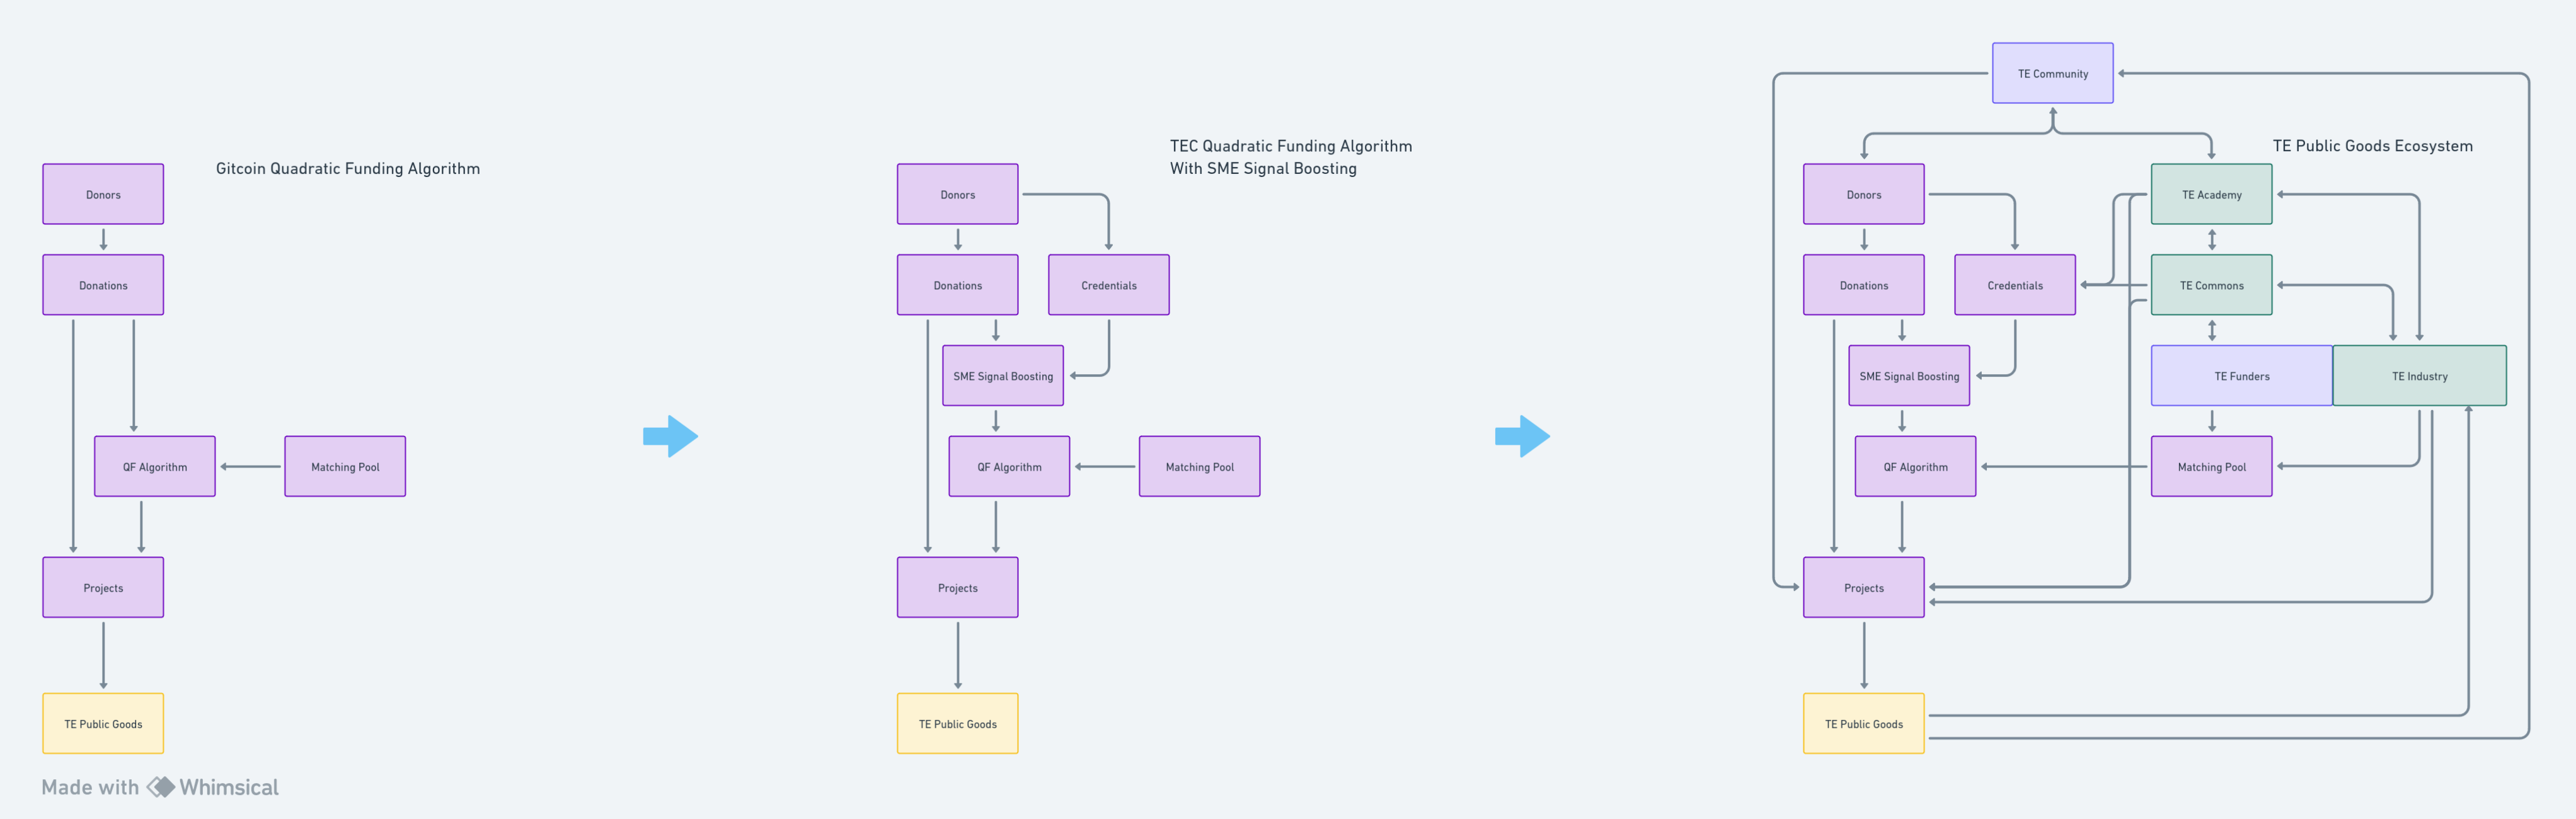![image.png]()

Link to the above board: https://whimsical.com/original-qfsme-mechanism-flowchart-QjXRdbkFmBcXBhnV175K9z 

Resources


* https://arxiv.org/pdf/2010.01193.pdf
* https://arxiv.org/pdf/1809.06421.pdf
* https://vitalik.ca/general/2019/12/07/quadratic.html
* https://qf.gitcoin.co/?grant=&grant=&grant=&match=1000
* https://medium.com/token-engineering-commons/expertise-and-quadratic-funding-bd4f0c5c3e23 

The following is a data science illustration of The foundational paper on FDFPGs. This is meant to be part one of a two part paper review, with a future modeling of Quadratic Funding and Matching Funds Requirments by Pasquini at Gitcoin. 

This worik is for educational purposes in the domain of token engineering. This work is meant to illustrate a data science approach to systems based modeling. This work is in the domain of digital signal processing, with primary foundations in machine learning, big data, data science, economics, and computing science, as those are the backgrounds of the primary authors. This work is funded by  with the Token Engineering Commons and Griff Green. 

# A Flexible Design for Funding Public Goods

Bhuterin, Hitzig, Weyl on A Flexible Design for Funding Public Goods. 

https://arxiv.org/pdf/1809.06421.pdf

The following is a data science illustration of The foundational paper on FDFPGs. This is meant to be part one of a two part paper review, with a future modeling of Quadratic Funding and Matching Funds Requirments by Pasquini at Gitcoin. 

This worik is for educational purposes in the domain of token engineering. This work is meant to illustrate a data science approach to systems based modeling. This work is in the domain of digital signal processing, with primary foundations in machine learning, big data, data science, economics, and computing science, as those are the backgrounds of the primary authors. This work is funded by  with the Token Engineering Commons and Griff Green. 

## 3.0 Model

This is the foundational setup in the paper.

In [1]:
import numpy as np

# Number of Citizens in the Society
N = 30

# Society is a set of citizens
society = list(range(N))

# Community is a random subset of the society. The community size is from 25 up to size of the society.
community = np.random.choice(a=list(society), size=np.random.randint(25, len(society)), replace=False, p=None)

# Public Goods are proposed by community members. Cardinality is from 20 up to size of the community.
public_goods = list(enumerate(np.random.choice(a=list(community), size=np.random.randint(20, len(community)), replace=True, p=None)))

In [2]:
community

array([ 0,  2,  6, 22, 12,  9, 19, 13, 20,  7, 23, 10, 28, 17, 14, 26, 18,
       25, 15, 16, 21,  5, 11,  1,  4, 24])

In [3]:
public_goods

[(0, 11),
 (1, 16),
 (2, 12),
 (3, 23),
 (4, 28),
 (5, 17),
 (6, 26),
 (7, 24),
 (8, 1),
 (9, 9),
 (10, 20),
 (11, 20),
 (12, 12),
 (13, 2),
 (14, 4),
 (15, 16),
 (16, 28),
 (17, 2),
 (18, 20),
 (19, 24),
 (20, 0)]

In [4]:
len(society)

30

In [5]:
len(community)

26

In [6]:
len(public_goods)

21

## 3.1 Individual Preferences and Actions

### Value Function Generators

The paper calls for 
* Concave, 
* Smooth, 
* Increasing preferences towards the funding of public goods.

The following function generator, generates value functions in the domain of {[0,1],[0,1]}.

In [7]:
import param
import numpy as np
import panel as pn
import hvplot.pandas
import pandas as pd

class ConcaveFunctionGenerator(param.Parameterized):
    f0 = param.Number(default=0.2, bounds=(0, 1), doc="Value of f(0)")
    f1 = param.Number(default=0.8, bounds=(0, 1), softbounds=(0, 1), doc="Value of f(1)")
    steepness = param.Number(default=5, bounds=(1, 20), doc="Steepness of the curve")

    def __init__(self, **params):
        super().__init__(**params)
        self._update_f1_bounds()

    @param.depends('f0', watch=True)
    def _update_f1_bounds(self):
        # Clip the value of f1 if it's below f0
        self.f1 = max(self.f0, self.f1)
        
        # Update the lower bound of f1 to be the value of f0
        self.param['f1'].bounds = (self.f0, 1)
        
    def x(self):
        return np.linspace(0, 1, 400)

    @param.depends('f0', 'f1', 'steepness')
    def f(self, x):
        # Using the negative exponential function as a base
        y = 1 - np.exp(-self.steepness * x)
        
        # Adjusting the function to start at f0 and end at f1
        y = self.f0 + (self.f1 - self.f0) * (y - y.min()) / (y.max() - y.min())
        
        return y

    @param.depends('f0', 'f1', 'steepness')
    def view(self):
        x = self.x()
        y = self.f(x)
        df = pd.DataFrame({'x': x, 'y': y})
        return df.hvplot.line(x='x', y='y', ylim=(0, 1.01))

concave_gen = ConcaveFunctionGenerator()
pn.Row(concave_gen.param, concave_gen.view).servable()


Row
    [0] Column(margin=(5, 10), name='ConcaveFunctionGenerator'...)
        [0] StaticText(value='<b>ConcaveFunctionGenerat...)
        [1] FloatSlider(name='F0', value=0.2)
        [2] FloatSlider(name='F1', start=0.2, value=0.8)
        [3] FloatSlider(end=20, name='Steepness', start=1, value=5)
    [1] ParamMethod(method, _pane=HoloViews, defer_load=False)

The concave value generator has the following properties:
1. f0 = f(0) is in [0,1]
2. f1 = f(1) is in [f0,1]
3. f(x) = 1 - e**(-s*x)
4. The negative exponential function provides a smooth, concave, increasing function from f0 to f1 with a parameterized steepness.

The class dynamically clips f1 to satisfy property 2. Such as in the following example:

In [8]:
ConcaveFunctionGenerator(f0=1,f1=0)

ConcaveFunctionGenerator(f0=1, f1=1, name='ConcaveFunctionGenerator00955', steepness=5)

Here we propose parameter generators for sampling concave functions

In [9]:
import numbergen as ng
import numpy as np


# For CurveGenerator
def concave_function_parameters_generator():
    return dict(
        f0=ng.BoundedNumber(generator=ng.NormalRandom(mu=0.1, sigma=0.3), bounds=(0,1))(),
        f1=ng.BoundedNumber(generator=ng.NormalRandom(mu=0.5, sigma=0.4), bounds=(0,1))(),
        steepness=ng.UniformRandom(lbound=1, ubound=20)(),
    )

This method generates random parameters given the distributions described for f0, f1, and steepness above. 
* f0 is a normal distribution at (0.1,0.3), clipped at (0,1)
* f0 is a normal distribution at (0.5,0.4), clipped at (0,1)
* steepness is a uniform distribution at (1,20)

In [10]:
concave_function_parameters_generator()

{'f0': 0, 'f1': 0.7464456609157466, 'steepness': 13.64715026343476}

In [11]:
value_functions = [ConcaveFunctionGenerator(**concave_function_parameters_generator()) for p_i in range(len(public_goods)*len(society))]

Here we can see all of the preferences of the citizens. These are the value functions V_p_i(F_p). There is one preference function for each V_p_i in {public_goods}X{citizens}. Cardinality is len(public_goods)*len(citizens).

#### Visualizing Sampled Value Functions

In [124]:
import pandas as pd

pd.DataFrame([s.param.values() for s in value_functions])

sample_p_i_slider = pn.widgets.IntSlider(name='Utility Value Function', start=0, end=len(value_functions)-1)

pn.Row(sample_p_i_slider, pn.bind(lambda i: value_functions[i].view(), i=sample_p_i_slider))

Row
    [0] IntSlider(end=629, name='Utility Value Function')
    [1] ParamFunction(function, _pane=HoloViews, defer_load=False)

#### Value Functions Dataset

Create a Dataframe! These are citizen preferences by funding amounts for public goods. Take Funding Amount as the Index by applying a transpose. 

In [125]:
df_value_functions = pd.DataFrame([s.f(s.x()) for s in value_functions])
df_value_functions = df_value_functions.T
df_value_functions.shape

(400, 630)

Make Funding the Index from 0 to 100

In [126]:
df_value_functions.index = np.linspace(0,1,len(df_value_functions))
df_value_functions.index.name = "funding"

Label the Columns by {public_goods}X{Citizens}.

In [127]:
df_value_functions.columns = [(p, i) for p in public_goods for i in society]
df_value_functions.columns.name = "value_p_i"

Number of columns is len(public_goods)*len(society).

In [128]:
df_value_functions

value_p_i,"((0, 11), 0)","((0, 11), 1)","((0, 11), 2)","((0, 11), 3)","((0, 11), 4)","((0, 11), 5)","((0, 11), 6)","((0, 11), 7)","((0, 11), 8)","((0, 11), 9)",...,"((20, 0), 20)","((20, 0), 21)","((20, 0), 22)","((20, 0), 23)","((20, 0), 24)","((20, 0), 25)","((20, 0), 26)","((20, 0), 27)","((20, 0), 28)","((20, 0), 29)"
funding,,,,,,,,,,,,,,,,,,,,,
0.000000,0.000000,0.059506,0.000000,0.134349,0.170137,0.609173,0.000000,0.000000,0.524546,0.290851,...,0.337717,0.202016,0.000000,0.341077,0.139441,0.568878,0.000000,0.000000,0.085058,0.203913
0.002506,0.035754,0.062593,0.023203,0.152799,0.184208,0.618780,0.039265,0.002304,0.528620,0.291572,...,0.341928,0.204731,0.005429,0.346989,0.152424,0.584521,0.031135,0.019718,0.102617,0.218828
0.005013,0.069987,0.065672,0.045513,0.170820,0.197880,0.627957,0.076646,0.004599,0.532598,0.292290,...,0.346082,0.207413,0.010792,0.352815,0.165160,0.599477,0.061180,0.038629,0.119506,0.233108
0.007519,0.102763,0.068743,0.066963,0.188421,0.211164,0.636724,0.112234,0.006885,0.536484,0.293006,...,0.350180,0.210064,0.016087,0.358556,0.177651,0.613777,0.090171,0.056768,0.135752,0.246781
0.010025,0.134146,0.071806,0.087587,0.205612,0.224072,0.645100,0.146114,0.009163,0.540280,0.293721,...,0.354221,0.212684,0.021317,0.364213,0.189903,0.627449,0.118147,0.074166,0.151379,0.259872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.989975,0.840556,0.813917,0.602320,0.927229,0.666406,0.824114,0.818375,0.470854,0.699796,0.469271,...,0.646287,0.429812,0.434778,0.744361,0.817329,0.925205,0.888608,0.482470,0.545931,0.554658
0.992481,0.840556,0.814992,0.602320,0.927231,0.666407,0.824114,0.818375,0.471364,0.699797,0.469531,...,0.646306,0.429837,0.434818,0.744379,0.817335,0.925205,0.888608,0.482470,0.545931,0.554658
0.994987,0.840556,0.816064,0.602320,0.927233,0.666407,0.824114,0.818375,0.471872,0.699797,0.469789,...,0.646324,0.429861,0.434857,0.744396,0.817341,0.925205,0.888608,0.482470,0.545931,0.554658


Display Citizen Preferences for Funding.

In [129]:
# Takes rendering time.
# df_value_functions.hvplot.line(x='funding', color='blue', alpha=0.1, line_width=3, ylabel='Value to Citizens', title='Smooth, Concave, Increasing Value Functions')

Mean preferences for funding public goods.

In [130]:
df_value_functions['mean'] = df_value_functions.mean(axis=1)
df_value_functions['std'] = df_value_functions.std(axis=1)
df_value_functions['low'] = df_value_functions['mean'] - df_value_functions['std']
df_value_functions['high'] = df_value_functions['mean'] + df_value_functions['std']

df_value_functions.hvplot.line(y='mean', ylabel='Value to Society') * df_value_functions.hvplot.area(y='low',y2='high', alpha=0.5, title='Mean Value to Society Given Funding')

:Overlay
   .Curve.I :Curve   [funding]   (mean)
   .Area.I  :Area   [funding]   (low,high)

Moving on..

In [131]:
df_value_functions.drop(['mean','std','low','high'],axis=1,inplace=True)

Each citizen i can make contributions to the funding of each public good p out of their resources c_p_i. The total utility then of citizen i is: [sum(V_p_i(F_p))  - c_p_i - t_i for all p in public_goods]

To calculate the above, we need F_p which is a vector of how much funding is achieved by each public good. We can sample a distribution of funding ammounts.

### Public Goods Funding Generators

#### Distributions Explorer

In [132]:
public_goods_funding_model = {'constant_value': 0.5,
 'distribution_type': 'exponential',
 'lambda_param': 2.8000000000000003,
 'mean': 0.2,
 'n': len(public_goods),
 'name': 'PublicGoodsFundingDistributionGenerator53483',
 'std_dev': 0.2}

In [133]:
import param
import numpy as np
import pandas as pd
import panel as pn
import hvplot.pandas

class PublicGoodsFundingDistributionGenerator(param.Parameterized):
    distribution_type = param.ObjectSelector(default="normal", objects=["normal", "constant", "uniform", "exponential"])
    mean = param.Number(default=0.5, bounds=(0, 1))
    n = param.Integer(default=100, bounds=(1, 1000))
    
    # Additional parameters for specific distributions
    std_dev = param.Number(default=0.1, bounds=(0, 0.5))  # for normal distribution
    constant_value = param.Number(default=0.5, bounds=(0, 1))  # for constant distribution
    lambda_param = param.Number(default=1.0, bounds=(0.1, 5))  # for exponential distribution
    
    @param.depends('distribution_type', 'mean', 'n', 'std_dev', 'constant_value', 'lambda_param')
    def generate_distribution(self):
        if self.distribution_type == "normal":
            distribution = np.clip(np.random.normal(self.mean, self.std_dev, self.n), 0, 1)
        elif self.distribution_type == "constant":
            distribution = np.full(self.n, self.constant_value)
        elif self.distribution_type == "uniform":
            distribution = np.random.uniform(0, 1, self.n)
        elif self.distribution_type == "exponential":
            distribution = np.clip(np.random.exponential(1/self.lambda_param, self.n), 0, 1)
        distribution = pd.Series(distribution, name='Public Goods Funding Distribution')
        return distribution / distribution.sum()
        
    
    @param.depends('distribution_type', 'mean', 'n', 'std_dev', 'constant_value', 'lambda_param')
    def view(self):
        data = self.generate_distribution()
        df = pd.DataFrame({'Value': data})
        return df.hvplot.hist('Value', bins=30, xlim=(0, 1), title='Public Goods Funding Histogram')

# Create an instance
dist_gen = PublicGoodsFundingDistributionGenerator(**public_goods_funding_model)

# Use panel to render the interactive system
pn.Row(dist_gen.param, dist_gen.view).servable()


Row
    [0] Column(margin=(5, 10), name='PublicGoodsFundingDistrib...)
        [0] StaticText(value='<b>PublicGoodsFundingDist...)
        [1] Select(name='Distribution type', options=OrderedDict([('normal', ...]), value='exponential')
        [2] FloatSlider(name='Mean', value=0.2)
        [3] IntSlider(end=1000, name='N', start=1, value=21)
        [4] FloatSlider(end=0.5, name='Std dev', value=0.2)
        [5] FloatSlider(name='Constant value', value=0.5)
        [6] FloatSlider(end=5, name='Lambda param', start=0.1, value=2.8000000000000003)
    [1] ParamMethod(method, _pane=HoloViews, defer_load=False)

#### Saving State with Params

In [134]:
dist_gen.param.values()

{'constant_value': 0.5,
 'distribution_type': 'exponential',
 'lambda_param': 2.8000000000000003,
 'mean': 0.2,
 'n': 21,
 'name': 'PublicGoodsFundingDistributionGenerator53483',
 'std_dev': 0.2}

In [135]:
dist_gen.generate_distribution()

0     0.043709
1     0.113348
2     0.017831
3     0.045429
4     0.021173
5     0.113348
6     0.113348
7     0.071857
8     0.032561
9     0.016038
10    0.002902
11    0.012223
12    0.062154
13    0.113348
14    0.046260
15    0.045076
16    0.030715
17    0.007285
18    0.017681
19    0.062417
20    0.011295
Name: Public Goods Funding Distribution, dtype: float64

#### Public Goods Pareto Distribution

In [136]:
import numpy as np

def generate_pareto(n, alpha=2):
    # Generate Pareto samples
    samples = np.random.pareto(alpha, n)
    
    # Normalize to make them sum to 1
    normalized_samples = samples / samples.sum()
    
    # Clip values to [0,1]
    clipped_samples = np.clip(normalized_samples, 0, 1)
    
    # Adjust to ensure they still sum to 1 after clipping
    clipped_samples /= clipped_samples.sum()
    
    return clipped_samples

n = len(public_goods)
pareto_samples = generate_pareto(n)


In [137]:
pd.DataFrame(pareto_samples).sort_values(0,ascending=False).reset_index(drop=True).hvplot(title='Public Goods Funding Distribution', xlabel='Public Good', ylabel='Funding')

:Curve   [index]   (0)

In [138]:
generate_public_goods_pareto_distribution = lambda n: pd.Series(generate_pareto(n), name='Public Goods Funding Distribution')
public_goods_funding_distribution = generate_public_goods_pareto_distribution(n=len(public_goods))
public_goods_funding_distribution

0     0.078469
1     0.055370
2     0.083537
3     0.047666
4     0.027140
5     0.011348
6     0.015226
7     0.016472
8     0.009371
9     0.014114
10    0.010593
11    0.012284
12    0.017460
13    0.010835
14    0.027778
15    0.015176
16    0.029712
17    0.352443
18    0.144278
19    0.001335
20    0.019393
Name: Public Goods Funding Distribution, dtype: float64

### Citizen Contributions Generator

Given a citizen i, this model selects a k public goods to donate to. The number of public goods to donate to is sampled from a beta decay centered at 8 in range [1,len(public_goods)].

Once k is sampled, a normal distribution of size k is sampled, and padded with 0s to be of size n. Then all is shuffled to distribute 0s randomly.

In [139]:
import numpy as np
from icecream import ic
ic.configureOutput(prefix='ic|',outputFunction=print)

n = len(public_goods)
ic(n)
k = int(np.clip(np.random.exponential(8), 1, n))
ic(k)
distribution = np.pad(np.abs(np.random.normal(size=k)), (0, n-k))
np.random.shuffle(distribution)
distribution /= distribution.sum()

ic|n: 21
ic|k: 2


In [140]:
import param
import panel as pn
import hvplot.pandas
import pandas as pd
import numpy as np
from icecream import ic

ic.configureOutput(prefix='ic|', outputFunction=print)

class CustomDistributionGenerator(param.Parameterized):
    n = param.Integer(default=100, bounds=(1, 1000), constant=True)
    mean_exponential = param.Integer(default=4, bounds=(1, 50))
    data = param.Array(precedence=-1)
    
    def __init__(self, **params):
        super().__init__(**params)
        self.generate_distribution()
    
    def f(self):
        k = int(np.clip(np.random.exponential(self.mean_exponential), 1, self.n))
        distribution = np.pad(np.abs(np.random.normal(size=k)), (0, self.n-k))
        np.random.shuffle(distribution)
        distribution /= distribution.sum()
        return distribution
    
    def x(self):
        return np.arange(self.n)
    
    @param.depends('n', 'mean_exponential', watch=True)
    def generate_distribution(self):
        self.data = self.f()
    
    @param.depends('data')
    def view(self):
        df = pd.DataFrame({'Value': self.data})
        return df.hvplot.step('index', 'Value', xlim=(0, self.n), ylim=(0, 1.01), title='Sample Public Goods Funding Amounts by Citizin I')

# Create an instance
dist_gen = CustomDistributionGenerator(n=len(public_goods))

# Use panel to render the interactive system
pn.Row(dist_gen.param, dist_gen.view).servable()


Row
    [0] Column(margin=(5, 10), name='CustomDistributionGenerat...)
        [0] StaticText(value='<b>CustomDistributionGene...)
        [1] IntSlider(disabled=True, end=1000, name='N', start=1, value=21)
        [2] IntSlider(end=50, name='Mean exponential', start=1, value=4)
    [1] ParamMethod(method, _pane=HoloViews, defer_load=False)

### The Contributions Dataset

The above can be used to sample a contributions vector for each citizen to generate the contributions matrix. The matrix should be {society}X{public_good}

In [141]:
len(public_goods)

21

In [142]:
len(society)

30

Generate public goods funding contributions for each citizen in the society.

In [143]:
contributions = pd.DataFrame([CustomDistributionGenerator(n=len(public_goods)).data for i in society])

contributions.columns.name = 'Public Good'
contributions.index.name = 'Citizen'

contributions

Public Good,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
Citizen,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
1,0.076021,0.013022,0.050554,0.022935,0.065086,0.003473,0.062867,0.066996,0.028859,0.048879,...,0.043717,0.089278,0.037926,0.059564,0.118351,0.066261,0.013039,0.051088,0.020590,0.009315
2,0.000000,0.000000,0.251424,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.748576,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.054127,0.000000,0.945873,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.122825,0.000000,0.103012,0.154834,0.000000,...,0.301506,0.000000,0.035179,0.064378,0.000000,0.075554,0.000000,0.000000,0.000000,0.000000


In [144]:
contributions.sum()

Public Good
0     0.511523
1     2.562214
2     1.417248
3     1.424277
4     0.149546
5     1.119790
6     2.264042
7     0.718800
8     0.765624
9     6.395179
10    0.764847
11    0.347137
12    2.255364
13    0.317731
14    2.411406
15    0.345392
16    0.916504
17    0.963881
18    0.546847
19    3.695741
20    0.106906
dtype: float64

In [145]:
contributions.sum(axis=1)

Citizen
0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    1.0
14    1.0
15    1.0
16    1.0
17    1.0
18    1.0
19    1.0
20    1.0
21    1.0
22    1.0
23    1.0
24    1.0
25    1.0
26    1.0
27    1.0
28    1.0
29    1.0
dtype: float64

In [146]:
contributions.sum().sum()

29.999999999999996

Public Goods Funded Per Citizen. In other words, signal preference per citizen.

In [147]:
h1 = contributions.hvplot.heatmap(title="Signal Preference Per Citizen", cmap='Blues', fontscale=1.2, width=800, height=800, xlabel='Public Good', ylabel='Citizen', clabel='Amount Contributed from citizen i to public_good p.').opts(default_tools=[])
h1

:HeatMap   [columns,index]   (value)

Citizen Cost Distribution per Public Good. In other words, cost distribution per public good.

In [148]:
public_goods_funding = (contributions / contributions.sum(axis=0))

In [149]:
public_goods_funding.sum(axis=0)

Public Good
0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    1.0
14    1.0
15    1.0
16    1.0
17    1.0
18    1.0
19    1.0
20    1.0
dtype: float64

In [150]:
public_goods_funding.sum(axis=1)

Citizen
0     0.270582
1     1.802522
2     0.294456
3     0.773217
4     0.443387
5     0.156368
6     0.156368
7     0.441688
8     1.730222
9     1.449880
10    0.414696
11    0.441688
12    0.172750
13    0.804183
14    1.283752
15    0.443387
16    0.156368
17    0.390287
18    0.702111
19    0.390287
20    1.278076
21    1.071825
22    0.270582
23    0.414696
24    0.288122
25    0.755228
26    0.156368
27    1.240233
28    0.725439
29    2.081233
dtype: float64

In [151]:
public_goods_funding.sum().sum()

21.0

In [152]:
h2 = public_goods_funding.hvplot.heatmap(title='Cost Distribution per Public Good', cmap='Reds', fontscale=1.2, width=800, height=800, xlabel='Public Good', ylabel='Citizen', clabel='Amount Contributed from citizen i to public_good p.').opts(default_tools=[])
h2

:HeatMap   [columns,index]   (value)

In [153]:
h1 + h2

:Layout
   .HeatMap.I  :HeatMap   [columns,index]   (value)
   .HeatMap.II :HeatMap   [columns,index]   (value)

### Normalized Contributions

In [154]:
# Normalize relative to our public_goods funding distribution.
normalized_contributions = contributions * public_goods_funding_distribution / contributions.sum()

In [155]:
h3 = normalized_contributions.hvplot.heatmap(title="Normalized Contributions", cmap='Purples', fontscale=1.2, width=800, height=800, xlabel='Public Good', ylabel='Citizen', clabel='Amount Contributed from citizen i to public_good p.').opts(default_tools=[])
h3

:HeatMap   [columns,index]   (value)

#### The Normalized (Original) Public Goods Distribution

In [156]:
normalized_contributions.sum(axis=0)

Public Good
0     0.078469
1     0.055370
2     0.083537
3     0.047666
4     0.027140
5     0.011348
6     0.015226
7     0.016472
8     0.009371
9     0.014114
10    0.010593
11    0.012284
12    0.017460
13    0.010835
14    0.027778
15    0.015176
16    0.029712
17    0.352443
18    0.144278
19    0.001335
20    0.019393
dtype: float64

#### The Normalized Citizen Cost Distribution

In [157]:
normalized_contributions.sum(axis=1)

Citizen
0     0.000361
1     0.062189
2     0.016472
3     0.064056
4     0.007742
5     0.002207
6     0.002207
7     0.006725
8     0.022537
9     0.044214
10    0.011520
11    0.006725
12    0.003566
13    0.016592
14    0.275125
15    0.007742
16    0.002207
17    0.021610
18    0.033467
19    0.021610
20    0.114174
21    0.040332
22    0.000361
23    0.011520
24    0.003475
25    0.007971
26    0.002207
27    0.118405
28    0.007172
29    0.065510
dtype: float64

In [158]:
normalized_contributions.sum().sum()

0.9999999999999999

### The Total Utility of Citizens

#### Value Functions Dataset Revisited

Melting preferences to get groupby on public good or on citizen.

In [159]:
df_value_functions_melted = df_value_functions.melt(ignore_index=False)
df_value_functions_melted['public_good'] = df_value_functions_melted['value_p_i'].astype(str).apply(eval).apply(lambda x: x[0]).astype(str)
df_value_functions_melted['citizen'] = df_value_functions_melted['value_p_i'].astype(str).apply(eval).apply(lambda x: x[1]).astype(str)
df_value_functions_melted

,value_p_i,value,public_good,citizen
funding,,,,
0.000000,"((0, 11), 0)",0.000000,"(0, 11)",0
0.002506,"((0, 11), 0)",0.035754,"(0, 11)",0
0.005013,"((0, 11), 0)",0.069987,"(0, 11)",0
0.007519,"((0, 11), 0)",0.102763,"(0, 11)",0
0.010025,"((0, 11), 0)",0.134146,"(0, 11)",0
...,...,...,...,...
0.989975,"((20, 0), 29)",0.554658,"(20, 0)",29
0.992481,"((20, 0), 29)",0.554658,"(20, 0)",29
0.994987,"((20, 0), 29)",0.554658,"(20, 0)",29


Groupby funding and public good to get mean funding preferences per public good.

Display mean value function per public good.

In [160]:
df_value_functions_melted.groupby(['funding', 'public_good'])[['value']].mean().reset_index().hvplot.line(y='value', by='public_good', alpha=0.8, line_width=4, x='funding', title='Mean Value to Society per Public Good Given Funding')

:NdOverlay   [public_good]
   :Curve   [funding]   (value)

Display mean value function per citizen.

In [161]:
df_value_functions_melted.groupby(['funding', 'citizen'])[['value']].mean().reset_index().hvplot.line(y='value', by='citizen', alpha=0.8, line_width=4, x='funding', title='Mean Value per Citizen as Public Goods are Funded')

:NdOverlay   [citizen]
   :Curve   [funding]   (value)

Total value per public good given funding.

In [162]:
df_value_functions_melted.pivot_table(index='funding', columns='public_good', values='value', aggfunc='sum')

public_good,"(0, 11)","(1, 16)","(10, 20)","(11, 20)","(12, 12)","(13, 2)","(14, 4)","(15, 16)","(16, 28)","(17, 2)",...,"(19, 24)","(2, 12)","(20, 0)","(3, 23)","(4, 28)","(5, 17)","(6, 26)","(7, 24)","(8, 1)","(9, 9)"
funding,,,,,,,,,,,,,,,,,,,,,
0.000000,6.765643,3.839080,3.047133,6.119391,5.547906,7.589079,5.936383,5.635947,6.300424,6.747964,...,3.283098,5.276316,5.363252,6.082313,8.340246,4.248371,5.654183,4.498769,4.291639,2.290555
0.002506,7.072014,4.227662,3.438698,6.465076,5.784513,7.792414,6.222965,5.902401,6.528727,7.022415,...,3.647039,5.637971,5.668276,6.337435,8.560320,4.537339,5.878555,4.833268,4.516991,2.695287
0.005013,7.368218,4.602976,3.817356,6.799162,6.013578,7.989540,6.500174,6.160615,6.749157,7.287340,...,3.998857,5.988139,5.963335,6.585171,8.772607,4.817339,6.095582,5.155987,4.735452,3.085760
0.007519,7.654637,4.965533,4.183570,7.122072,6.235373,8.180670,6.768356,6.410875,6.962029,7.543117,...,4.339003,6.327232,6.248797,6.825766,8.977426,5.088682,6.305540,5.467370,4.947266,3.462523
0.010025,7.931634,5.315823,4.537785,7.434214,6.450159,8.366010,7.027842,6.653457,7.167649,7.790105,...,4.667910,6.655643,6.525011,7.059457,9.175079,5.351671,6.508696,5.767844,5.152666,3.826106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.989975,18.517369,17.695419,17.216906,17.531131,14.767351,15.775663,16.915756,16.632558,15.201563,16.753771,...,17.104773,19.413623,16.807426,17.446373,16.709606,15.568600,15.517714,15.279689,13.531362,15.943385
0.992481,18.519518,17.696036,17.218256,17.531264,14.768101,15.776688,16.916717,16.634587,15.202399,16.754638,...,17.106956,19.414909,16.808085,17.448143,16.710914,15.569326,15.520679,15.280359,13.531754,15.944194
0.994987,18.521659,17.696647,17.219597,17.531397,14.768847,15.777707,16.917670,16.636607,15.203229,16.755500,...,17.109130,19.416186,16.808738,17.449902,16.712215,15.570045,15.523632,15.281026,13.532142,15.944997


Total value per citizen per funding of public goods.

In [163]:
df_value_functions_melted.pivot_table(index='funding', columns='citizen', values='value', aggfunc='sum')

citizen,0,1,10,11,12,13,14,15,16,17,...,27,28,29,3,4,5,6,7,8,9
funding,,,,,,,,,,,,,,,,,,,,,
0.000000,2.547059,2.421810,3.688145,3.573590,5.435455,3.654691,5.103927,3.276429,5.733952,3.969225,...,3.276951,5.298418,2.561686,2.727388,2.263630,5.744846,4.677986,3.386634,3.376752,2.096117
0.002506,2.806568,2.633493,3.901952,3.761039,5.588422,3.865424,5.244176,3.466809,5.926048,4.203332,...,3.544850,5.503401,2.697682,2.971307,2.518331,5.895894,4.933020,3.657456,3.601587,2.330433
0.005013,3.058125,2.837697,4.108653,3.942199,5.737264,4.067709,5.379379,3.651505,6.111171,4.429082,...,3.802748,5.700778,2.830062,3.207592,2.764574,6.042223,5.178823,3.919155,3.818329,2.557008
0.007519,3.302000,3.034720,4.308505,4.117317,5.882110,4.261899,5.509743,3.830706,6.289596,4.646808,...,4.051045,5.890842,2.958946,3.436510,3.002683,6.184004,5.415755,4.172076,4.027305,2.776129
0.010025,3.538451,3.224847,4.501755,4.286625,6.023083,4.448332,5.635463,4.004593,6.461585,4.856828,...,4.290129,6.073873,3.084448,3.658320,3.232967,6.321398,5.644163,4.416550,4.228830,2.988073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.989975,12.267627,10.937638,11.102285,10.842850,12.459541,9.646132,10.437789,10.572341,11.890456,12.101196,...,12.087950,11.313955,9.438866,11.651101,11.810615,11.916670,12.661332,13.414055,12.352260,11.329515
0.992481,12.267811,10.940185,11.102650,10.843267,12.460282,9.646550,10.439148,10.572520,11.890646,12.102037,...,12.089202,11.314106,9.439841,11.651191,11.811193,11.917539,12.661563,13.415479,12.355034,11.331106
0.994987,12.267992,10.942722,11.103012,10.843679,12.461017,9.646965,10.440502,10.572698,11.890834,12.102872,...,12.090447,11.314256,9.440809,11.651279,11.811766,11.918403,12.661793,13.416896,12.357797,11.332689


#### The Value Tensor

In [164]:
df_value_tensor = df_value_functions_melted.pivot_table(index='funding', columns=['citizen','public_good'], values='value')
df_value_tensor

citizen             0                                                    \
public_good   (0, 11)   (1, 16)  (10, 20)  (11, 20)  (12, 12)   (13, 2)   
funding                                                                   
0.000000     0.000000  0.129456  0.000000  0.004312  0.372933  0.536776   
0.002506     0.035754  0.148909  0.003337  0.042352  0.378859  0.536776   
0.005013     0.069987  0.167928  0.006623  0.078939  0.384532  0.536776   
0.007519     0.102763  0.186522  0.009859  0.114128  0.389962  0.536776   
0.010025     0.134146  0.204700  0.013045  0.147973  0.395160  0.536776   
...               ...       ...       ...       ...       ...       ...   
0.989975     0.840556  0.999990  0.217625  1.000000  0.511449  0.536776   
0.992481     0.840556  0.999993  0.217633  1.000000  0.511449  0.536776   
0.994987     0.840556  0.999995  0.217640  1.000000  0.511449  0.536776   
0.997494     0.840556  0.999998  0.217648  1.000000  0.511449  0.536776   
1.000000     0.840556  1.000000  0.217655  1.000000  0.511449  0.536776   

citizen                                              ...        9            \
public_good   (14, 4)  (15, 16)  (16, 28)   (17, 2)  ... (19, 24)   (2, 12)   
funding                                              ...                      
0.000000     0.000000  0.222287  0.315675  0.318941  ...      0.0  0.109386   
0.002506     0.015569  0.233551  0.319208  0.325277  ...      0.0  0.151074   
0.005013     0.030836  0.244556  0.322600  0.331413  ...      0.0  0.190810   
0.007519     0.045809  0.255308  0.325854  0.337356  ...      0.0  0.228687   
0.010025     0.060492  0.265813  0.328976  0.343113  ...      0.0  0.264790   
...               ...       ...       ...       ...  ...      ...       ...   
0.989975     0.805113  0.712504  0.403167  0.520320  ...      0.0  1.000000   
0.992481     0.805120  0.712506  0.403167  0.520320  ...      0.0  1.000000   
0.994987     0.805127  0.712507  0.403167  0.520320  ...      0.0  1.000000   
0.997494     0.805134  0.712508  0.403167  0.520320  ...      0.0  1.000000   
1.000000     0.805140  0.712509  0.403167  0.520320  ...      0.0  1.000000   

citizen                                                                  \
public_good   (20, 0)   (3, 23)   (4, 28)   (5, 17)   (6, 26)   (7, 24)   
funding                                                                   
0.000000     0.000000  0.135818  0.734003  0.082927  0.000000  0.000000   
0.002506     0.009941  0.147925  0.734003  0.086604  0.000680  0.026816   
0.005013     0.019438  0.159692  0.734003  0.090247  0.001356  0.052914   
0.007519     0.028511  0.171129  0.734003  0.093855  0.002028  0.078311   
0.010025     0.037177  0.182244  0.734003  0.097429  0.002697  0.103027   
...               ...       ...       ...       ...       ...       ...   
0.989975     0.222424  0.566939  0.734003  0.461302  0.110006  0.999998   
0.992481     0.222424  0.566939  0.734003  0.461386  0.110084  0.999998   
0.994987     0.222424  0.566939  0.734003  0.461471  0.110161  0.999999   
0.997494     0.222424  0.566940  0.734003  0.461554  0.110238  0.999999   
1.000000     0.222424  0.566940  0.734003  0.461636  0.110315  1.000000   

citizen                          
public_good    (8, 1)    (9, 9)  
funding                          
0.000000     0.400517  0.000000  
0.002506     0.400517  0.006946  
0.005013     0.400517  0.013827  
0.007519     0.400517  0.020644  
0.010025     0.400517  0.027397  
...               ...       ...  
0.989975     0.400517  0.725236  
0.992481     0.400517  0.725407  
0.994987     0.400517  0.725576  
0.997494     0.400517  0.725743  
1.000000     0.400517  0.725909  

[400 rows x 630 columns]

#### The Value Outcomes Tensor

Sampling by public goods funding distribution.

In [166]:
index_obj = pd.Index(df_value_tensor.index)
nearest_indices = index_obj.get_indexer(public_goods_funding_distribution, method='nearest')
df_value_outcomes_tensor = df_value_tensor.iloc[nearest_indices]
df_value_outcomes_tensor

citizen             0                                                    \
public_good   (0, 11)   (1, 16)  (10, 20)  (11, 20)  (12, 12)   (13, 2)   
funding                                                                   
0.077694     0.622099  0.567970  0.082871  0.702365  0.475738  0.536776   
0.055138     0.517511  0.470512  0.062741  0.577390  0.458517  0.536776   
0.082707     0.640288  0.587065  0.086978  0.724673  0.478728  0.536776   
0.047619     0.472516  0.433365  0.055385  0.525001  0.451098  0.536776   
0.027569     0.319464  0.321069  0.034024  0.351318  0.425822  0.536776   
0.012531     0.164194  0.222472  0.016182  0.180524  0.400135  0.536776   
0.015038     0.192963  0.239847  0.019272  0.211832  0.404898  0.536776   
0.017544     0.220509  0.256834  0.022314  0.241944  0.409456  0.536776   
0.010025     0.134146  0.204700  0.013045  0.147973  0.395160  0.536776   
0.015038     0.192963  0.239847  0.019272  0.211832  0.404898  0.536776   
0.010025     0.134146  0.204700  0.013045  0.147973  0.395160  0.536776   
0.012531     0.164194  0.222472  0.016182  0.180524  0.400135  0.536776   
0.017544     0.220509  0.256834  0.022314  0.241944  0.409456  0.536776   
0.010025     0.134146  0.204700  0.013045  0.147973  0.395160  0.536776   
0.027569     0.319464  0.321069  0.034024  0.351318  0.425822  0.536776   
0.015038     0.192963  0.239847  0.019272  0.211832  0.404898  0.536776   
0.030075     0.341629  0.336241  0.036840  0.376101  0.429486  0.536776   
0.353383     0.838724  0.964121  0.193310  0.995900  0.511158  0.536776   
0.145363     0.772998  0.765331  0.128922  0.896029  0.500483  0.536776   
0.002506     0.035754  0.148909  0.003337  0.042352  0.378859  0.536776   
0.020050     0.246883  0.273441  0.025309  0.270905  0.413820  0.536776   

citizen                                              ...        9            \
public_good   (14, 4)  (15, 16)  (16, 28)   (17, 2)  ... (19, 24)   (2, 12)   
funding                                              ...                      
0.077694     0.365647  0.474041  0.378794  0.445567  ...      0.0  0.798497   
0.055138     0.281186  0.418545  0.367845  0.420646  ...      0.0  0.689788   
0.082707     0.382485  0.484875  0.380724  0.450196  ...      0.0  0.816919   
0.047619     0.249571  0.397313  0.363194  0.410614  ...      0.0  0.641807   
0.027569     0.155628  0.332893  0.347575  0.378643  ...      0.0  0.474377   
0.012531     0.074891  0.276077  0.331973  0.348688  ...      0.0  0.299204   
0.015038     0.089012  0.286105  0.334849  0.354088  ...      0.0  0.332007   
0.017544     0.102861  0.295902  0.337608  0.359318  ...      0.0  0.363274   
0.010025     0.060492  0.265813  0.328976  0.343113  ...      0.0  0.264790   
0.015038     0.089012  0.286105  0.334849  0.354088  ...      0.0  0.332007   
0.010025     0.060492  0.265813  0.328976  0.343113  ...      0.0  0.264790   
0.012531     0.074891  0.276077  0.331973  0.348688  ...      0.0  0.299204   
0.017544     0.102861  0.295902  0.337608  0.359318  ...      0.0  0.363274   
0.010025     0.060492  0.265813  0.328976  0.343113  ...      0.0  0.264790   
0.027569     0.155628  0.332893  0.347575  0.378643  ...      0.0  0.474377   
0.015038     0.089012  0.286105  0.334849  0.354088  ...      0.0  0.332007   
0.030075     0.168188  0.341615  0.349821  0.383101  ...      0.0  0.498980   
0.353383     0.754085  0.694056  0.402905  0.518100  ...      0.0  0.998967   
0.145363     0.545806  0.585213  0.395160  0.488786  ...      0.0  0.944773   
0.002506     0.015569  0.233551  0.319208  0.325277  ...      0.0  0.151074   
0.020050     0.116441  0.305475  0.340256  0.364383  ...      0.0  0.393078   

citizen                                                                  \
public_good   (20, 0)   (3, 23)   (4, 28)   (5, 17)   (6, 26)   (7, 24)   
funding                                                                   
0.077694     0.168524  0.388657  0.734003  0.182088  0.019432  0.569439   
0.

#### Value Outcomes Tensor Values

In [167]:
values = df_value_outcomes_tensor.unstack().values.reshape(len(df_value_outcomes_tensor), len(df_value_outcomes_tensor.columns.levels[0]), len(df_value_outcomes_tensor.columns.levels[1]))

In [168]:
values.shape

(21, 30, 21)

#### Extract the Diagonal Plane of The Value Tensor

In [169]:
# Extract the diagonal plane
diagonal_plane = values[np.arange(values.shape[0]), :, np.arange(values.shape[2])]
diagonal_plane.shape

(21, 30)

####  The Value Outcomes Matrix V_P(F_P)

In [170]:
utility_given_funding = pd.DataFrame(diagonal_plane, index=public_goods, columns=society)
utility_given_funding.index.name = "public_goods"
utility_given_funding.columns.name = "citizens"
utility_given_funding

citizens,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
public_goods,,,,,,,,,,,,,,,,,,,,,
"(0, 11)",0.622099,0.567970,0.082871,0.702365,0.475738,0.536776,0.365647,0.474041,0.378794,0.445567,...,0.018157,0.151477,0.664341,0.362925,0.603906,0.102144,0.074749,0.000000,0.501077,0.139961
"(1, 16)",0.474653,0.146142,0.480842,0.577971,0.443416,0.126474,0.388024,0.415559,0.305464,0.000000,...,0.281312,0.354534,0.323226,0.528369,0.037895,0.049020,0.399578,0.304017,0.299158,0.386982
"(2, 12)",0.309176,0.475795,0.069216,0.089114,0.150813,0.741960,0.846384,0.195974,0.651669,0.216506,...,0.338673,0.552602,0.000000,0.438116,0.036828,0.577937,0.622496,0.350641,0.357544,0.921269
"(3, 23)",0.464047,0.464069,0.018059,0.431798,0.716168,0.050689,0.545665,0.441180,0.566862,0.327820,...,0.405067,0.495568,0.041049,0.470293,0.333383,0.487103,0.512011,0.200115,0.583627,0.700177
"(4, 28)",0.148515,0.112117,0.152040,0.227211,0.067665,0.177855,0.489955,0.238761,0.000000,0.438389,...,0.202647,0.612335,0.265146,0.715753,0.234081,0.079703,0.202780,0.290351,0.690809,0.009255
"(5, 17)",0.490581,0.006034,0.000000,0.392977,0.321920,0.625965,0.052513,0.104271,0.070557,0.147947,...,0.598151,0.321961,0.337130,0.096459,0.097157,0.471866,0.163213,0.896955,0.084531,0.064045
"(6, 26)",0.730964,0.663806,0.541840,0.554474,0.178570,0.000000,0.200506,0.146770,0.241409,0.106318,...,0.068964,0.361267,0.013614,0.576623,0.721828,0.069076,0.564589,0.080310,0.034542,0.168700
"(7, 24)",0.104301,0.073494,0.022170,0.426559,0.150537,0.385544,0.577190,0.439391,0.727190,0.165798,...,0.402971,0.197328,0.083548,0.102641,0.562081,0.147492,0.088278,0.017085,0.235773,0.065311
"(8, 1)",0.173409,0.172362,0.174568,0.266666,0.050974,0.018392,0.274162,0.286049,0.195923,0.426487,...,0.065052,0.105380,0.059335,0.140417,0.521543,0.229922,0.026178,0.428893,0.287763,0.100245


#### Net Value Per Citizen Given Funding

In [67]:
utility_given_funding.sum()

citizens
0     6.122117
1     5.928935
2     3.753360
3     7.617624
4     5.353279
5     5.505962
6     5.964718
7     7.217972
8     7.549529
9     7.197423
10    6.607367
11    5.656262
12    7.088311
13    4.508747
14    5.722813
15    8.724400
16    4.807502
17    5.342423
18    4.023007
19    5.360162
20    4.779334
21    7.162064
22    5.879455
23    5.288099
24    7.803832
25    5.976333
26    4.709010
27    6.718227
28    6.962735
29    7.246366
dtype: float64

#### Net Value Produced per Public Good Given Funding

In [68]:
utility_given_funding.sum(axis=1)

public_goods
(0, 11)      6.525098
(1, 16)      6.574722
(2, 12)      6.478103
(3, 23)      7.801289
(4, 28)      7.458983
(5, 17)     14.049588
(6, 26)     13.820274
(7, 24)      7.529772
(8, 1)       6.407200
(9, 9)       6.063089
(10, 20)     6.038074
(11, 20)     7.921733
(12, 12)    11.343348
(13, 2)      6.784902
(14, 4)      5.515863
(15, 16)     9.943723
(16, 28)     7.345155
(17, 2)      7.021544
(18, 20)    11.932027
(19, 24)    15.560216
(20, 0)     10.462667
dtype: float64

In [69]:
utility_given_funding_melted = utility_given_funding.melt(ignore_index=False)

In [70]:
utility_given_funding_melted.reset_index().dtypes

public_goods     object
citizens          int64
value           float64
dtype: object

#### Visualizing Value

In [72]:
u = utility_given_funding_melted.reset_index()

u['citizens'] = u['citizens'].astype(str)
u['value'] = u['value'].astype(float)

import random, string
address = lambda k=8: "0x"+"".join(random.choices(string.hexdigits, k=k))
addresses = lambda n, k: [address(k) for a in range(n)]
address()

public_goods_address_map = dict(zip(u['public_goods'].unique(), [address() for a in range(u['public_goods'].nunique())]))


u['public_goods'] = u.public_goods.map(public_goods_address_map)

u.hvplot.heatmap(x='citizens', y='public_goods', C='value', title="Value Matrix Given Funding Levels", cmap='Greens', fontscale=1.2, width=1100, height=850, xlabel='Citizen', ylabel='Public Good', clabel='Amount of value produced by public_good p for citizen i.').opts(default_tools=[])

:HeatMap   [citizens,public_goods]   (value)

In [73]:
utility_given_funding_melted = utility_given_funding.melt(ignore_index=False).reset_index()
utility_given_funding_melted

,public_goods,citizens,value
0,"(0, 11)",0,0.319464
1,"(1, 16)",0,0.473940
2,"(2, 12)",0,0.309176
3,"(3, 23)",0,0.151372
4,"(4, 28)",0,0.133114
...,...,...,...
625,"(16, 28)",29,0.165024
626,"(17, 2)",29,0.703051
627,"(18, 20)",29,0.453006
628,"(19, 24)",29,0.529143


In [74]:
utility_given_funding_melted.groupby('citizens').sum()['value']

citizens
0     6.122117
1     5.928935
2     3.753360
3     7.617624
4     5.353279
5     5.505962
6     5.964718
7     7.217972
8     7.549529
9     7.197423
10    6.607367
11    5.656262
12    7.088311
13    4.508747
14    5.722813
15    8.724400
16    4.807502
17    5.342423
18    4.023007
19    5.360162
20    4.779334
21    7.162064
22    5.879455
23    5.288099
24    7.803832
25    5.976333
26    4.709010
27    6.718227
28    6.962735
29    7.246366
Name: value, dtype: float64

In [75]:
contributions.sum(axis=1)

Citizen
0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    1.0
14    1.0
15    1.0
16    1.0
17    1.0
18    1.0
19    1.0
20    1.0
21    1.0
22    1.0
23    1.0
24    1.0
25    1.0
26    1.0
27    1.0
28    1.0
29    1.0
dtype: float64

In [76]:
citizen_taxes = pd.Series([0.05] * len(society), name='Taxes')
citizen_taxes

0     0.05
1     0.05
2     0.05
3     0.05
4     0.05
5     0.05
6     0.05
7     0.05
8     0.05
9     0.05
10    0.05
11    0.05
12    0.05
13    0.05
14    0.05
15    0.05
16    0.05
17    0.05
18    0.05
19    0.05
20    0.05
21    0.05
22    0.05
23    0.05
24    0.05
25    0.05
26    0.05
27    0.05
28    0.05
29    0.05
Name: Taxes, dtype: float64

#### Citizen Utility Equation
A citizens utility is their net value from public goods minus their total contributions minus any taxes that they pay.

In [171]:
citizen_utility = utility_given_funding_melted.groupby('citizens').sum()['value'] - contributions.sum(axis=1) - citizen_taxes

citizen_utility

citizens
0     5.072117
1     4.878935
2     2.703360
3     6.567624
4     4.303279
5     4.455962
6     4.914718
7     6.167972
8     6.499529
9     6.147423
10    5.557367
11    4.606262
12    6.038311
13    3.458747
14    4.672813
15    7.674400
16    3.757502
17    4.292423
18    2.973007
19    4.310162
20    3.729334
21    6.112064
22    4.829455
23    4.238099
24    6.753832
25    4.926333
26    3.659010
27    5.668227
28    5.912735
29    6.196366
dtype: float64

## 3.2 Funding Mechanisms

A funding mechanism in our flexible public goods setting defines the total amount of funding received for each good in the set P.  
It can be computed by summing the contributions matrix:

F is the set of funding Outcomes for all the public_goods. F is a vector of size of {public_goods}, a real valued outcome for each public good. Funding Outcome.

In [78]:
contributions.sum(axis=0)

Public Good
0     1.316874
1     0.207407
2     0.216470
3     1.463016
4     0.723623
5     2.522340
6     1.903252
7     0.552265
8     0.701445
9     0.996633
10    2.237036
11    1.223310
12    0.247958
13    1.981782
14    1.299284
15    3.464922
16    2.540437
17    2.423629
18    0.250185
19    2.350466
20    1.377665
dtype: float64

Contributions are the vectors C_p = (C_p1, C_p2, ..., C_pn) for c_p_i in {Contributions from citizen i to public good p} where the subscripts index citizens. So there are n citizens.


In [79]:
contributions

Public Good,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
Citizen,,,,,,,,,,,,,,,,,,,,,
0,0.076585,0.015068,0.100936,0.126074,0.000000,0.046855,0.000000,0.104698,0.051438,0.051603,...,0.000000,0.093610,0.069919,0.095142,0.072426,0.000000,0.058235,0.000000,0.037412,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.586719,0.000000,0.000000,0.000000,0.413281,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.428563,0.000000,0.338666,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.232771
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
6,0.000000,0.000000,0.000000,0.119845,0.151274,0.212620,0.150515,0.064601,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.301144,0.000000,0.000000,0.000000
7,0.000000,0.005172,0.097511,0.151623,0.035628,0.000000,0.056718,0.019261,0.000000,0.000000,...,0.077585,0.125016,0.000000,0.000000,0.000000,0.249476,0.058022,0.000000,0.027146,0.022617
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Compute c_p_i.

In [80]:
public_good_p=4
citizen_i=6

c_p_i = contributions[public_good_p][citizen_i]
c_p_i

0.1512735851727688

Formally, a funding mechanism is a mapping from the set of all individual contributions to funding levels for all goods.

Cp -> F

In [81]:
def funding_mechanism(contributions: pd.DataFrame)-> pd.Series:
    return funding_outcome

In [82]:
def funding_outcome(contributions: pd.DataFrame, mechanism, **params)-> pd.Series:
    funding_outcome: pd.Series = mechanism(contributions, **params)
    return funding_outcome

In [83]:
def mechanism_1(contributions: pd.DataFrame) -> pd.Series:
    """Everybody gets the Donation that was donated to them."""
    return contributions.sum()

In [84]:
funding_outcome(contributions, mechanism_1)

Public Good
0     1.316874
1     0.207407
2     0.216470
3     1.463016
4     0.723623
5     2.522340
6     1.903252
7     0.552265
8     0.701445
9     0.996633
10    2.237036
11    1.223310
12    0.247958
13    1.981782
14    1.299284
15    3.464922
16    2.540437
17    2.423629
18    0.250185
19    2.350466
20    1.377665
dtype: float64

In [85]:
def mechanism_2(contributions):
    """Everybody gets the Mean Donation that was donated to them."""
    return contributions.mean()

In [86]:
funding_outcome(contributions, mechanism_2)

Public Good
0     0.043896
1     0.006914
2     0.007216
3     0.048767
4     0.024121
5     0.084078
6     0.063442
7     0.018409
8     0.023382
9     0.033221
10    0.074568
11    0.040777
12    0.008265
13    0.066059
14    0.043309
15    0.115497
16    0.084681
17    0.080788
18    0.008340
19    0.078349
20    0.045922
dtype: float64

In [87]:
def mechanism_3(contributions):
    """Everybody gets the Max Donation that was donated to them."""
    return contributions.max()

In [88]:
funding_outcome(contributions, mechanism_3)

Public Good
0     0.498533
1     0.187166
2     0.100936
3     0.428563
4     0.239112
5     0.738910
6     1.000000
7     0.297727
8     0.258978
9     0.499747
10    1.000000
11    1.000000
12    0.125016
13    1.000000
14    1.000000
15    1.000000
16    0.872108
17    0.553645
18    0.191438
19    1.000000
20    0.937355
dtype: float64

### Definition 1 (Funding Mechanisms)

A funding_mechanism phi : C_p -> F determines the total level of funding for each public good p in public_goods. Such that:


phi(c_p_i) = {F_p} for p in public_goods.

The above expression kind of denotes the whole system. It denots that there is a mapping from the contribution made from citizen i to public good p to the funding outcome for public goods p.

In other words, it determines how much a donation impacts the funding of a public good. 

### Budget Balancing
Deficits or surpluses of donations are subsidized by taxes to make up for the difference in funding.

In [89]:
taxes = lambda contributions, mechanism: funding_outcome(contributions, mechanism) - contributions.sum()

In [90]:
taxes(contributions, mechanism_1)

Public Good
0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
20    0.0
dtype: float64

In [91]:
taxes(contributions, mechanism_2)

Public Good
0    -1.272978
1    -0.200493
2    -0.209254
3    -1.414249
4    -0.699502
5    -2.438262
6    -1.839810
7    -0.533856
8    -0.678064
9    -0.963412
10   -2.162468
11   -1.182533
12   -0.239693
13   -1.915723
14   -1.255975
15   -3.349425
16   -2.455756
17   -2.342841
18   -0.241846
19   -2.272117
20   -1.331743
dtype: float64

In [92]:
taxes(contributions, mechanism_3)

Public Good
0    -0.818341
1    -0.020241
2    -0.115534
3    -1.034453
4    -0.484511
5    -1.783430
6    -0.903252
7    -0.254539
8    -0.442468
9    -0.496886
10   -1.237036
11   -0.223310
12   -0.122942
13   -0.981782
14   -0.299284
15   -2.464922
16   -1.668329
17   -1.869984
18   -0.058747
19   -1.350466
20   -0.440310
dtype: float64

In [93]:
taxes(contributions, mechanism_1).sum()

0.0

In [94]:
taxes(contributions, mechanism_2).sum()

-28.999999999999996

In [95]:
taxes(contributions, mechanism_3).sum()

-17.070766030819478

## 3.3 Welfare and Optimality

Calculating total social welfare given the simple model above.

### Total Social Welfare

In [96]:
total_social_welfare = utility_given_funding.sum() - contributions.sum(axis=1)
total_social_welfare

citizens
0     5.122117
1     4.928935
2     2.753360
3     6.617624
4     4.353279
5     4.505962
6     4.964718
7     6.217972
8     6.549529
9     6.197423
10    5.607367
11    4.656262
12    6.088311
13    3.508747
14    4.722813
15    7.724400
16    3.807502
17    4.342423
18    3.023007
19    4.360162
20    3.779334
21    6.162064
22    4.879455
23    4.288099
24    6.803832
25    4.976333
26    3.709010
27    5.718227
28    5.962735
29    6.246366
dtype: float64

 ### FDFPG Optimization for V_P(F_P)
 
 This is the function to optimize. Determine F_P such V_P(F_P) is maximized given a fixed sum(F_P).

In [97]:
total_social_welfare.sum()

152.5773700444187

In [98]:
contributions.sum().sum()

30.0

Given the citizen value_functions (preferences), determine the contributions matrix such that V_P(F_P) is maximized.

In [99]:
value_functions[:5]

[ConcaveFunctionGenerator(f0=0, f1=0.8405556953048481, name='ConcaveFunctionGenerator00966', steepness=17.343308578183965),
 ConcaveFunctionGenerator(f0=0.059506009532187064, f1=0.8182000511259386, name='ConcaveFunctionGenerator00972', steepness=1.0656891283158465),
 ConcaveFunctionGenerator(f0=0, f1=0.6023199734021798, name='ConcaveFunctionGenerator00978', steepness=15.67477807496722),
 ConcaveFunctionGenerator(f0=0.13434941075855644, f1=0.9272359599246909, name='ConcaveFunctionGenerator00984', steepness=9.393275519270416),
 ConcaveFunctionGenerator(f0=0.1701367187032754, f1=0.6664069719789747, name='ConcaveFunctionGenerator00990', steepness=11.476459954226774)]

In [100]:
df_value_functions

citizen             0                                                    \
public_good   (0, 11)   (1, 16)  (10, 20)  (11, 20)  (12, 12)   (13, 2)   
funding                                                                   
0.000000     0.000000  0.129456  0.000000  0.004312  0.372933  0.536776   
0.002506     0.035754  0.148909  0.003337  0.042352  0.378859  0.536776   
0.005013     0.069987  0.167928  0.006623  0.078939  0.384532  0.536776   
0.007519     0.102763  0.186522  0.009859  0.114128  0.389962  0.536776   
0.010025     0.134146  0.204700  0.013045  0.147973  0.395160  0.536776   
...               ...       ...       ...       ...       ...       ...   
0.989975     0.840556  0.999990  0.217625  1.000000  0.511449  0.536776   
0.992481     0.840556  0.999993  0.217633  1.000000  0.511449  0.536776   
0.994987     0.840556  0.999995  0.217640  1.000000  0.511449  0.536776   
0.997494     0.840556  0.999998  0.217648  1.000000  0.511449  0.536776   
1.000000     0.840556  1.000000  0.217655  1.000000  0.511449  0.536776   

citizen                                              ...        9            \
public_good   (14, 4)  (15, 16)  (16, 28)   (17, 2)  ... (19, 24)   (2, 12)   
funding                                              ...                      
0.000000     0.000000  0.222287  0.315675  0.318941  ...      0.0  0.109386   
0.002506     0.015569  0.233551  0.319208  0.325277  ...      0.0  0.151074   
0.005013     0.030836  0.244556  0.322600  0.331413  ...      0.0  0.190810   
0.007519     0.045809  0.255308  0.325854  0.337356  ...      0.0  0.228687   
0.010025     0.060492  0.265813  0.328976  0.343113  ...      0.0  0.264790   
...               ...       ...       ...       ...  ...      ...       ...   
0.989975     0.805113  0.712504  0.403167  0.520320  ...      0.0  1.000000   
0.992481     0.805120  0.712506  0.403167  0.520320  ...      0.0  1.000000   
0.994987     0.805127  0.712507  0.403167  0.520320  ...      0.0  1.000000   
0.997494     0.805134  0.712508  0.403167  0.520320  ...      0.0  1.000000   
1.000000     0.805140  0.712509  0.403167  0.520320  ...      0.0  1.000000   

citizen                                                                  \
public_good   (20, 0)   (3, 23)   (4, 28)   (5, 17)   (6, 26)   (7, 24)   
funding                                                                   
0.000000     0.000000  0.135818  0.734003  0.082927  0.000000  0.000000   
0.002506     0.009941  0.147925  0.734003  0.086604  0.000680  0.026816   
0.005013     0.019438  0.159692  0.734003  0.090247  0.001356  0.052914   
0.007519     0.028511  0.171129  0.734003  0.093855  0.002028  0.078311   
0.010025     0.037177  0.182244  0.734003  0.097429  0.002697  0.103027   
...               ...       ...       ...       ...       ...       ...   
0.989975     0.222424  0.566939  0.734003  0.461302  0.110006  0.999998   
0.992481     0.222424  0.566939  0.734003  0.461386  0.110084  0.999998   
0.994987     0.222424  0.566939  0.734003  0.461471  0.110161  0.999999   
0.997494     0.222424  0.566940  0.734003  0.461554  0.110238  0.999999   
1.000000     0.222424  0.566940  0.734003  0.461636  0.110315  1.000000   

citizen                          
public_good    (8, 1)    (9, 9)  
funding                          
0.000000     0.400517  0.000000  
0.002506     0.400517  0.006946  
0.005013     0.400517  0.013827  
0.007519     0.400517  0.020644  
0.010025     0.400517  0.027397  
...               ...       ...  
0.989975     0.400517  0.725236  
0.992481     0.400517  0.725407  
0.994987     0.400517  0.725576  
0.997494     0.400517  0.725743  
1.000000     0.400517  0.725909  

[400 rows x 630 columns]

In [101]:
contributions

Public Good,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
Citizen,,,,,,,,,,,,,,,,,,,,,
0,0.076585,0.015068,0.100936,0.126074,0.000000,0.046855,0.000000,0.104698,0.051438,0.051603,...,0.000000,0.093610,0.069919,0.095142,0.072426,0.000000,0.058235,0.000000,0.037412,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.586719,0.000000,0.000000,0.000000,0.413281,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.428563,0.000000,0.338666,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.232771
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
6,0.000000,0.000000,0.000000,0.119845,0.151274,0.212620,0.150515,0.064601,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.301144,0.000000,0.000000,0.000000
7,0.000000,0.005172,0.097511,0.151623,0.035628,0.000000,0.056718,0.019261,0.000000,0.000000,...,0.077585,0.125016,0.000000,0.000000,0.000000,0.249476,0.058022,0.000000,0.027146,0.022617
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000


How do we generate an optimal contributions matrix given the value tensor above?

Let's continue building. 

## 3.4 Suboptimal Mechanisms

### Definition 3 Private Contributions Mechanism

In [102]:
def mechanism_1(contributions: pd.DataFrame) -> pd.Series:
    """Everybody gets the Donation that was donated to them."""
    return contributions.sum()

In [103]:
outcome_1 = funding_outcome(contributions, mechanism_1)
outcome_1

Public Good
0     1.316874
1     0.207407
2     0.216470
3     1.463016
4     0.723623
5     2.522340
6     1.903252
7     0.552265
8     0.701445
9     0.996633
10    2.237036
11    1.223310
12    0.247958
13    1.981782
14    1.299284
15    3.464922
16    2.540437
17    2.423629
18    0.250185
19    2.350466
20    1.377665
dtype: float64

In [104]:
outcome_1.sum()

30.0